In [657]:
import json
import numpy as np
import os

# !pip install pywebarchive
import webarchive


import re
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

In [658]:
# Load in data
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

gestureNames = ["Forward flick", "Right flick", "Right tilt", "Left flick", \
                "Left tilt", "Pull close", "Push away", "Turn to right", "Turn to left"]

# Import all webarchives in the directory
files = []
for r,d,f in os.walk("."):
    for file in f:
        if ".webarchive" in file and 'archivedData' not in r:
            files.append(os.path.join(r, file))


# Webarchive format -> parsed JSON dictionaries
fileData = []
for file in files:
    tmp = webarchive.open(file)
    jsonStr = cleanhtml(tmp._main_resource.data.decode())
    try:
        jsonData = json.loads(jsonStr)
        for key in jsonData.keys():
            jsonData[key] = json.loads(jsonData[key])
        fileData.append(jsonData)
    except:
        print("Failed on " + file)
print("Successfully parsed " + str(len(fileData)) + " trials")


Successfully parsed 5 trials


In [659]:
# Create list of each trial separately, tagged with user ID and everything
dataList = []

for subNum in range(len(fileData)):
    data = fileData[subNum]
    for evalName in data.keys():
        for gestureBlock in data[evalName]:
            for segment in gestureBlock:
                # Unpack each segment trial
                timestamp, detected, target, histories = segment

                detectedGest = detected[0]
                detectedGaze = detected[1]

                # Get the ground truth gesture and square out
                gestureTarget = target[0]
                gestureName = gestureNames[gestureTarget]
                gazeTarget = target[1]

                # Unpack the histories array
                headsize_hist, embeddings_hist, gazepreds_hist, IMU_hist, gestdetect_hist = histories

                dataList.append([subNum, evalName, gestureName, gazeTarget, timestamp, 
                                 gestureTarget, gazeTarget, detectedGest, detectedGaze, 
                                 headsize_hist, embeddings_hist, gazepreds_hist, gestdetect_hist, IMU_hist, 
                                ])

                
# Create dataframe out of the list
GAZELdata = pd.DataFrame(dataList, columns=['Subject', "Set", "Gesture Target Name", "Gaze Target", "Timestamp",
                               "Target Gesture", "Target Gaze", "Detected Gesture", "Detected Gaze",
                                "Headsize Hist", "Embeddings Hist", "Gazepreds Hist", "Gestpreds Hist", "IMU Hist"
                                   ])
# Target gestures are top to bottom
# | 1  5 |
# | 2  6 | 
# | 3  7 |
# | 4  8 |

In [660]:
# Filter the embeddings and gaze prediction histories based on movement
def getFirstActivity(lst):
    tmp = next((i for i,x in enumerate(lst) if sum(x) != 0), -1)
    # if tmp == -1: tmp = len(lst)
    return tmp


# Find index of first motion, then trim each gazepred and embedding history there. 
# Also remove the first three samples to get rid of reaction time
firstIndices = list(map(getFirstActivity, GAZELdata['Gestpreds Hist']))
GAZELdata['Gazepreds Hist'] = list(map(lambda x: x[0][3:x[1]], zip(GAZELdata['Gazepreds Hist'],firstIndices)))
GAZELdata['Embeddings Hist'] = list(map(lambda x: x[0][3:x[1]], zip(GAZELdata['Embeddings Hist'],firstIndices)))

# Then remove all rows where the length is too short (<5 samples)
GAZELdata = GAZELdata.loc[[len(x) >= 5 for x in GAZELdata['Gazepreds Hist']]]

# # Plot one of the eye histories for fun
# plt.plot(GAZELdata['Gazepreds Hist'][0])

In [661]:
# Add target locations in XY
GAZELdata['Gaze Target XY'] = np.zeros((len(GAZELdata), 2)).tolist()
def seg2GridCoords(segNum):
    return [(1 + (segNum-1)//4)/3, 1/8 + (((segNum-1) % 4) )/4]
def seg2ListCoords(segNum):
    return [0.5, 1/12 + (segNum-1)/6]

grids = [x[0]=='g' for x in GAZELdata['Set']]
lists = [not x for x in grids]

GAZELdata.loc[grids, 'Gaze Target XY'] = pd.Series([seg2GridCoords(x) for x in GAZELdata.loc[grids, 'Gaze Target']])
GAZELdata.loc[lists, 'Gaze Target XY'] = pd.Series([seg2ListCoords(x) for x in GAZELdata.loc[lists, 'Gaze Target']])

In [857]:
# Get the training and testing pairs from one subject
def getPairsFromTable(tbl, together=False): 
    c = []
    gridOrList = []
    gazeTargets = []
    for i in tbl.index:
        embeds = tbl.loc[i, 'Embeddings Hist']
        XY = tbl.loc[i, 'Gaze Target XY']
        if not together:
            for sample in embeds:
                c.append([sample, XY])
                gazeTargets.append(tbl.loc[i, 'Gaze Target'])
                gridOrList.append(tbl.loc[i, 'Set'])
        else:
            c.append([embeds[-6:],XY])
            gazeTargets.append(tbl.loc[i, 'Gaze Target'])
            gridOrList.append(tbl.loc[i, 'Set'])
    return c,gazeTargets, gridOrList

subNum = 1
subData = GAZELdata.loc[GAZELdata['Subject'] == subNum]

gridandlist1Ind = (GAZELdata['Set'] == "grid1_results") | (GAZELdata['Set'] == "list1_results")
gridandlist1 = subData.loc[gridandlist1Ind]

otherevalsInd = (GAZELdata['Set'] != "grid1_results") & (GAZELdata['Set'] != "list1_results")
otherevals = subData.loc[otherevalsInd]

In [663]:
# Functions for getting base error from a subject
def getBaseError(subjectData):
    a = np.array(subjectData['Gazepreds Hist'])
    b = [np.mean(x, axis=0) for x in a]

    return mean_absolute_error(subjectData['Gaze Target XY'].to_list(), b)

def getErrorWithModel(subjectData, model):
    a = subjectData['Gazepreds Hist']
#     b = [np.mean(x, axis=0) for x in a]    
    feats = subjectData['Embeddings Hist']
    b = [np.mean(model.predict(x), axis=0) for x in feats]

    return mean_absolute_error(subjectData['Gaze Target XY'].to_list(), b)

In [664]:
# List of all classifiers as models
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Classification
models = [
#     RadiusNeighborsClassifier(),
#     RadiusNeighborsClassifier(radius=.5),
    KNeighborsClassifier(n_neighbors=len(files)),
    ExtraTreesClassifier(),
    ExtraTreesClassifier(n_estimators=400),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=400),
    SGDClassifier(),
    LogisticRegression()
]



In [665]:
# List of all regressors as models
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold,cross_val_score

models = [
    ExtraTreesRegressor(),
#     ExtraTreesRegressor(n_estimators=300),
#     ExtraTreesRegressor(n_estimators=300, max_depth=10),
#     MLPRegressor(),
#     MLPRegressor(solver="lbfgs"),
#     MLPRegressor(hidden_layer_sizes=(32,128), max_iter=300, solver="lbfgs"),
#     KNeighborsRegressor(n_neighbors = len(files)), 
    RandomForestRegressor(), 
    ExtraTreesRegressor(), 
#     SVR(),
#     NuSVR(),
    LinearSVR(),
    LinearRegression(),
#     RANSACRegressor() # Broken
]

In [500]:
# Accuracy testing
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

train, trainGazetargs, trainSet = getPairsFromTable(gridandlist1)
test, testGazetargs, testSet = getPairsFromTable(otherevals)

trainx = [x[0] for x in train]
trainy = [x[1][0] for x in train]

testx = [x[0] for x in test]
testy = [x[1][0] for x in test]

# retrofitter = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=300, max_depth=10))
# retrofitter = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=300))
# retrofitter = MultiOutputRegressor(SVR())
# retrofitter = ExtraTreesRegressor(n_estimators=300)
# retrofitter = SVR()
scaler = StandardScaler()
train_X = scaler.fit_transform(trainx)

retrofitter = MLPRegressor(hidden_layer_sizes=(32,128), max_iter=350)
retrofitter.fit(train_X, trainy)
outs = retrofitter.predict(scaler.transform(testx))


# Mean Absolute Error for new model
# print("Test error on new model", mean_absolute_error(trainy, retrofitter.predict(trainx)))
print("Test error on new model", mean_absolute_error(testy, outs))
print("Baseline model error", getBaseError(subData))

Test error on new model 0.16922236209220284
Baseline model error 0.27484629646464576


In [858]:
# Classification Testing - different setups as functions
import scipy
mode = scipy.stats.mode

import copy
dcopy = copy.deepcopy
# train, trainGazetargs, trainSet = getPairsFromTable(gridandlist1, together=False)
# test, testGazetargs, testSet = getPairsFromTable(otherevals, together=False)

# trainx = [np.array(x[0]).flatten() for x in train]
# testx = [np.array(x[0]).flatten() for x in test]
# trainy = trainGazetargs
# testy = testGazetargs


def classifier_SingleEmbedThenVote(clf, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=False)
    test, testGazetargs, testSet = getPairsFromTable(testingDF, together=False)

    train_x = [np.array(x[0]).flatten() for x in train]
    testx = [np.array(x[0]).flatten() for x in test]
    train_y = trainGazetargs
    testy = testGazetargs
    
    clf.fit(train_x, train_y)
    
    # Test on real data
    voters = [clf.predict(x) for x in testingDF['Embeddings Hist']]
    voteOutputs = [mode(x).mode[0] for x in voters]
    preds = np.array(voteOutputs)
    gt = testingDF['Gaze Target'].to_numpy()
    print("score", sum(preds == gt)/len(preds))
    print("model", clf)
    return sum(preds == gt)/len(preds)

def classifier_separateXYSingleEmbedThenVote(clf, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=False)
    test, testGazetargs, testSet = getPairsFromTable(testingDF, together=False)

    train_x = [np.array(x[0]).flatten() for x in train]
    testx = [np.array(x[0]).flatten() for x in test]
    train_y_x = (np.array(trainGazetargs) > 4).astype(int) 
    a = np.array(trainGazetargs); a[a>4] -= 4
    train_y_y = a.copy()
    
    testy = testGazetargs
    test_y_x = (np.array(testGazetargs) > 4).astype(int) 
    a = np.array(testGazetargs); a[a>4] -= 4
    test_y_y = a.copy()
    
    # Make the two separate CLFs
    clf_x = clf
    clf_y = dcopy(clf)
    
    clf_x.fit(train_x, train_y_x)
    clf_y.fit(train_x, train_y_y)
    
    voters_x = [clf_x.predict(x) for x in testingDF['Embeddings Hist']]
    voters_y = [clf_y.predict(x) for x in testingDF['Embeddings Hist']]

    a = np.array(testingDF['Gaze Target'])
    gt_x = (a > 4).astype(int)
    a[a>4] -= 4
    gt_y = a

    voteOutputs_x = [mode(x).mode[0] for x in voters_x]
    voteOutputs_y = [mode(x).mode[0] for x in voters_y]

    score = sum((voteOutputs_y == gt_y) &(voteOutputs_x == gt_x))/len(gt_y)
    print("score", score)
    print("model", clf)
    return score

def classifier_separateXY6Embeds(clf, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=True)
    test, testGazetargs, testSet = getPairsFromTable(testingDF, together=True)

    train_x = [np.array(x[0]).flatten() for x in train]
    testx = [np.array(x[0]).flatten() for x in test]
    train_y_x = (np.array(trainGazetargs) > 4).astype(int) 
    a = np.array(trainGazetargs); a[a>4] -= 4
    train_y_y = a.copy()

    testy = testGazetargs
    test_y_x = (np.array(testGazetargs) > 4).astype(int) 
    a = np.array(testGazetargs); a[a>4] -= 4
    test_y_y = a.copy()

    # Make the two separate CLFs
    clf_x = clf
    clf_y = dcopy(clf)

    clf_x.fit(train_x, train_y_x)
    clf_y.fit(train_x, train_y_y)

    voters_x = [clf_x.predict([np.array(x[-6:]).flatten()]) for x in testingDF['Embeddings Hist']]
    voters_y = [clf_y.predict([np.array(x[-6:]).flatten()]) for x in testingDF['Embeddings Hist']]

    a = np.array(testingDF['Gaze Target'])
    gt_x = (a > 4).astype(int)
    a[a>4] -= 4
    gt_y = a

    score = sum((np.array(voters_y).flatten() == gt_y) & (np.array(voters_x).flatten() == gt_x))/len(gt_y)
    print("score", score)
    print("model", clf)
    return score
    

def classifier_6Embeds(clf, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=True)
    test, testGazetargs, testSet = getPairsFromTable(testingDF, together=True)

    train_x = [np.array(x[0]).flatten() for x in train]
    testx = [np.array(x[0]).flatten() for x in test]
    train_y = trainGazetargs
    testy = testGazetargs
    
    clf.fit(train_x, train_y)
    voters = [clf.predict([np.array(x[-6:]).flatten()]) for x in testingDF['Embeddings Hist']]
    preds = np.array(voters).flatten()
    gt = testingDF['Gaze Target'].to_numpy()
    print("score", sum(preds == gt)/len(preds))
    print("model", clf)
    return sum(preds == gt)/len(preds)

retroclasser = ExtraTreesClassifier(n_estimators=300)
# classifier_SingleEmbedThenVote(retroclasser, gridandlist1, otherevals)
# classifier_6Embeds(retroclasser, gridandlist1, otherevals)
classifier_separateXYSingleEmbedThenVote(retroclasser, gridandlist1, otherevals)




score 0.4425531914893617
model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


0.4425531914893617

In [856]:
# Regression testing, diff setups as functions
from sklearn.metrics import mean_absolute_error,accuracy_score
import scipy
mode = scipy.stats.mode

import copy
dcopy = copy.deepcopy

def regressor_6EmbedThenThresh(regr, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=True)
    trainx = [np.array(x[0]).flatten() for x in train]
    trainy = [x[1] for x in train]

    scaler = StandardScaler()
    train_X = scaler.fit_transform(trainx)

    regr = MultiOutputRegressor(regr)
    regr.fit(train_X, trainy)

    # Get real data

    GTs = np.array(testingDF['Gaze Target XY'].to_list())
    realXs = [np.array(x[-6:]).flatten().reshape(1,-1) for x in testingDF['Embeddings Hist']]
    predYs = [regr.predict(scaler.transform(x)) for x in realXs]
    predYs = np.array([x[0] for x in predYs])
    score = mean_absolute_error(GTs, np.array(predYs))
    print(score)
    return score

retrofitter = ExtraTreesRegressor(n_estimators=300)
regressor_6EmbedThenThresh(retrofitter, gridandlist1, otherevals)

0.17980748945147673


0.17980748945147673

In [834]:
def xyToSegGrid(lst):
    x,y = lst
    return int(((y//.25)+1) + 4*(x > .5))

def xyToSegList(lst):
    x,y = lst
    return int(y//(1/6) + 1)

def f(clf, dataset):
    newOutputs = [np.mean(clf.predict(x), axis=0) for x in dataset['Embeddings Hist']]
    print("Testing abs error on same conditions as base model", mean_absolute_error(dataset['Gaze Target XY'].tolist(), newOutputs))
    
    # Accuracy for new model
    predSegs = []
    for i in range(len(newOutputs)):
        curXY = newOutputs[i]
#         print(dataset.iloc[i])
        if dataset.iloc[i]["Set"][0] == "g":
            predSeg = xyToSegGrid(curXY)
        else:
            predSeg = xyToSegList(curXY)
        predSegs.append(predSeg)

    print("New Model Accuracy", accuracy_score(dataset['Gaze Target'].to_list(),predSegs))    
    print("Base Accuracy", accuracy_score(dataset['Gaze Target'].to_list(), dataset['Detected Gaze']))
    
    return newOutputs, predSegs

# predsXY, preds = f(retrofitter, gridandlist1)
predsXY, preds = f(retrofitter, otherevals)

0.7851212366350334

In [845]:
# realXs = [np.array(x[-6:]).flatten() for x in testingDF['Embeddings Hist']]
# testingDF['Gaze Target XY']

trainingDF = gridandlist1
testingDF = otherevals
regr = LinearRegression()

# regr = ExtraTreesRegressor(n_estimators=300)
# retrofitter.fit(trainx, trainy)

train, trainGazetargs, trainSet = getPairsFromTable(trainingDF, together=True)
trainx = [np.array(x[0]).flatten() for x in train]
trainy = [x[1] for x in train]

scaler = StandardScaler()
train_X = scaler.fit_transform(trainx)

regr = MultiOutputRegressor(regr)
regr.fit(train_X, trainy)

# Get real data

GTs = np.array(testingDF['Gaze Target XY'].to_list())
realXs = [regr.predict(scaler.transform(np.array(x[-6:]).flatten().reshape(1,-1))) for x in testingDF['Embeddings Hist']]

realXs = np.array([x[0] for x in realXs])
score = mean_absolute_error(GTs, np.array(realXs))
print(score)

0.5689792470987002


In [841]:
GTs[:5]
print(score)

0.18010665729020156


In [838]:
realXs[:5]

array([[ 0.87100238, -0.15243959],
       [ 2.51882758,  2.46432938],
       [ 0.58993548, -0.44390683],
       [ 0.70260075, -1.55732411],
       [ 0.03085101, -2.48876872]])

In [851]:
len(trainx)

115

In [854]:
# Testing out a lot of models at once
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=ConvergenceWarning)


train, trainGazetargs, trainSet = getPairsFromTable(gridandlist1, together=True)
test, testGazetargs, testSet = getPairsFromTable(otherevals, together=True)

trainx = [np.array(x[0]).flatten() for x in train]
testx = [np.array(x[0]).flatten() for x in test]

trainy = [x[1] for x in train]
testy = [x[1] for x in test]


def tryModel(clf):
    print(clf, end="\n")
    clf = MultiOutputRegressor(clf)
    scaler = StandardScaler()
    train_X = scaler.fit_transform(trainx)
    clf.fit(train_X, trainy)
    score = mean_absolute_error(testy, clf.predict(scaler.transform(testx)))
    print(score)
    print()
    return score


# trainy = trainGazetargs
# testy = testGazetargs
# def tryModel(clf):
#     print(clf, end="\n")
# #     train_X = scaler.fit_transform(trainx)
# #     clf.fit(train_X, trainy)
# #     score = mean_absolute_error(testy, clf.predict(scaler.transform(testx)))
# #     clf.fit(trainx, np.array(trainy))
# #     score = mean_absolute_error(testy, clf.predict(testx))
# #     score = clf.score(scaler.transform(testx), testy)
    
#     clf.fit(trainx, trainy)
#     score = clf.score(testx, testy)
#     print(score)
#     print()
#     return score
# return clf.score(scaler.transform(test_X), np.array(test_y)), clf, scaler



for model in models:
    tryModel(model)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators='warn',
                    n_jobs=None, oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
0.17991385372714483

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
0.18629571026722924

ExtraTreesRegressor(bootstrap=False, 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [760]:
# len(trainx[0])
[len(x) for x in train[0]]


[26, 26, 26, 26, 26, 26]

In [ ]:
# newFitterOuts = [np.mean(retrofitter.predict(x), axis=0) for x in otherevals['Embeddings Hist']]
# print("Testing abs error on same conditions as base model", mean_absolute_error(otherevals['Gaze Target XY'].tolist(), newFitterOuts))

# otherevals['Gaze Target XY'].tolist()
# newFitterOuts = [list(x) for x in newFitterOuts]
yea = otherevals['Gaze Target XY'].tolist()
# testingXY = newFitterOuts

# a = np.array()
b = [np.mean(x, axis=0) for x in subjectData['Gazepreds Hist']]
testingXY = newFitterOuts

x1 = [x[0] for x in testingXY]
x2 = [x[0] for x in yea]
xdiff = np.abs(np.array(x1) - np.array(x2))
print("x off", xdiff.mean())

x1 = [x[1] for x in testingXY]
x2 = [x[1] for x in yea]
xdiff = np.abs(np.array(x1) - np.array(x2))
print("y off", xdiff.mean())


# mean_absolute_error(otherevals['Gaze Target XY'].tolist(), newFitterOuts)

In [461]:
def xyToSegGrid(lst):
    x,y = lst
    return int(((y//.25)+1) + 4*(x > .5))

def xyToSegList(lst):
    x,y = lst
    return int(y//(1/6) + 1)

def f(clf, dataset):
    newOutputs = [np.mean(clf.predict(x), axis=0) for x in dataset['Embeddings Hist']]
    print("Testing abs error on same conditions as base model", mean_absolute_error(dataset['Gaze Target XY'].tolist(), newOutputs))
    
    # Accuracy for new model
    predSegs = []
    for i in range(len(newOutputs)):
        curXY = newOutputs[i]
#         print(dataset.iloc[i])
        if dataset.iloc[i]["Set"][0] == "g":
            predSeg = xyToSegGrid(curXY)
        else:
            predSeg = xyToSegList(curXY)
        predSegs.append(predSeg)

    print("New Model Accuracy", accuracy_score(dataset['Gaze Target'].to_list(),predSegs))    
    print("Base Accuracy", accuracy_score(dataset['Gaze Target'].to_list(), dataset['Detected Gaze']))
    
    return newOutputs, predSegs

# predsXY, preds = f(retrofitter, gridandlist1)
predsXY, preds = f(retrofitter, otherevals)
# a = pd.DataFrame([gridandlist1['Gaze Target'], preds, gridandlist1['Detected Gaze']],\
#                       columns = ["GT Segments", "retrofit segments", "base model segments"])


# gridandlist1
# f(retrofitter, otherevals)
# print("Base Accuracy", accuracy_score(otherevals['Gaze Target'].to_list(), otherevals['Gaze Target'].to_list()))

Testing abs error on same conditions as base model 0.19550472150244272
New Model Accuracy 0.2838983050847458
Base Accuracy 0.4194915254237288


In [456]:
# len(otherevals['Gaze Target'])
# len(preds)
# [np.mean(retrofitter.predict(x), axis=0) for x in otherevals['Embeddings Hist']]
# [np.mean(retrofitter.predict(x),axis=0) for x in otherevals['Embeddings Hist']]


# a = [retrofitter.predict(x) for x in otherevals['Embeddings Hist']]

# otherevals['Embeddings Hist']


In [457]:
[print(x,"\n") for x in otherevals['Embeddings Hist'][72]]

[0.1618652492761612, 0.0701904371380806, -0.91552734375, 0.37158203125, 0.10272216796875, -0.1264648586511612, -1.5507811307907104, -0.54736328125, 0.3569335639476776, -0.4257812798023224, -0.34814453125, 1.5351561307907104, 0.669921875, 0.330078125, 0.80712890625, 0.642578125, 0.63330078125, 0.646484375, 0.2332763820886612, 0.62451171875, 0.40673828125, 0.6396484375, -0.005474090576171875, -0.009918212890625, 0.007759095635265112, 0.0950927734375] 

[0.32666015625, 0.0176239050924778, -1.08203125, 0.58203125, 0.06854248046875, -0.2423095852136612, -1.4999998807907104, -0.59619140625, 0.263427734375, -0.6943359375, -0.58837890625, 1.5322264432907104, 0.65380859375, 0.2364502102136612, 0.80615234375, 0.638671875, 0.63232421875, 0.64453125, 0.2283935546875, 0.62353515625, 0.405517578125, 0.638671875, 0.01600647158920765, -0.029876716434955597, -0.0019083030056208372, 0.095947265625] 

[0.2487793266773224, 0.0243682861328125, -0.9868164658546448, 0.5317383408546448, 0.03778076171875, -0.2

[None, None, None, None, None, None, None, None, None, None, None]

In [404]:
def roundXY2(lstOfXYs):
    return np.around(np.array(lstOfXYs.to_list()),2)

def roundXY2oflist(lstOfXYs):
    return np.around(np.array(lstOfXYs),2)


a = pd.DataFrame()
a['GT'] = gridandlist1['Gaze Target']
a['New'] = preds
a['Base'] = gridandlist1['Detected Gaze']

a['GT XY'] = pd.Series(roundXY2(gridandlist1['Gaze Target XY']).tolist())
a['New XY'] = roundXY2oflist(predsXY).tolist()
a['Base XY'] = roundXY2oflist([np.mean(x, axis=0) for x in gridandlist1['Gazepreds Hist']]).tolist()

a

,GT,New,Base,GT XY,New XY,Base XY
0,6,7,6.0,"[0.67, 0.38]","[0.55, 0.53]","[0.86, 0.48]"
1,4,3,4.0,"[0.33, 0.88]","[0.48, 0.57]","[0.26, 0.89]"
2,1,6,1.0,"[0.33, 0.12]","[0.55, 0.48]","[0.05, 0.1]"
3,2,7,2.0,"[0.33, 0.38]","[0.56, 0.53]","[0.12, 0.42]"
4,8,3,8.0,"[0.67, 0.88]","[0.46, 0.63]","[1.01, 0.87]"
5,5,7,5.0,"[0.67, 0.12]","[0.53, 0.5]","[0.61, 0.22]"
6,3,7,4.0,"[0.33, 0.62]","[0.56, 0.53]","[0.15, 0.9]"
7,7,7,8.0,"[0.67, 0.62]","[0.52, 0.56]","[0.82, 0.81]"
8,8,7,8.0,"[0.67, 0.88]","[0.53, 0.56]","[0.93, 0.98]"
9,3,2,4.0,"[0.33, 0.62]","[0.48, 0.45]","[0.18, 0.84]"


In [ ]:
roundXY2oflist([np.mean(x, axis=0) for x in gridandlist1['Gazepreds Hist']])

In [334]:
xyToSegGrid([0.6666666666666666, 0.375])

6

In [326]:
# len(otherevals)
gridandlist1.head()

# print(predSegs[:10])
# print(otherevals['Gaze Target'][:10])

,Subject,Set,Gesture Target Name,Gaze Target,Timestamp,Target Gesture,Target Gaze,Detected Gesture,Detected Gaze,Headsize Hist,Embeddings Hist,Gazepreds Hist,Gestpreds Hist,IMU Hist,Gaze Target XY
0,0,grid1_results,Left flick,6,1615340384780,3,6,3,6.0,"[0.30224734877100423, 0.30944546044295973, 0.3...","[[-0.044525161385536194, 0.3891601264476776, -...","[[0.731187650525796, 0.48227639888475093], [0....","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[0.6464235638411402, 0.19402486358743487, -0...","[0.6666666666666666, 0.375]"
1,0,grid1_results,Left flick,4,1615340389560,3,4,3,4.0,"[0.3035961872467104, 0.3033918554893195, 0.301...","[[-1.6025389432907104, 1.1279296875, -1.749999...","[[0.3904400859198497, 0.8878785011526044], [0....","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[0.397971697522224, 0.6568024098109447, -0.3...","[0.3333333333333333, 0.875]"
2,0,grid1_results,Left flick,1,1615340398573,3,1,3,1.0,"[0.3089946410400718, 0.30877806269674807, 0.30...","[[0.77294921875, 2.244140386581421, -2.6757810...","[[0.022812940718674096, 0.10506334678541596], ...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[0.7129172163193597, 0.6739144882810597, -0....","[0.3333333333333333, 0.125]"
3,0,grid1_results,Left flick,2,1615340404140,3,2,3,2.0,"[0.3143517670029907, 0.312444084606332, 0.3127...","[[-0.1829833984375, 1.866210699081421, -2.5332...","[[0.1105132648286859, 0.42020881621316064], [0...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[-0.20187064319009035, -0.30736955834712215,...","[0.3333333333333333, 0.375]"
4,0,grid1_results,Left flick,8,1615340410342,3,8,3,8.0,"[0.30037894039833396, 0.3027644165867691, 0.30...","[[-1.9902342557907104, 0.0004739763680845499, ...","[[0.8670384133390192, 0.922068276249733], [0.9...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[0.5471147477432704, 2.502845554836187, 2.85...","[0.6666666666666666, 0.875]"


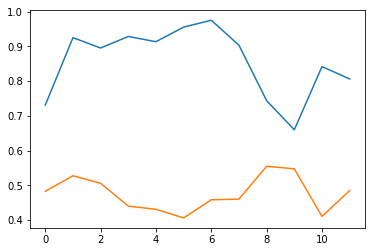

In [328]:
plt.plot(gridandlist1['Gazepreds Hist'][0])

In [247]:
# newFitterOuts
print(newFitterOuts[:5])
print(testSet[:5])
print(testGazetargs[:5])
# # Accuracy for new model
# predSegs = []
# for i in range(len(newFitterOuts)):
#     curXY = newFitterOuts[i]
#     if testSet[i][0] == "g":
#         predSeg = xyToSegGrid(curXY)
#     else:
#         predSeg = xyToSegList(curXY)
#     predSegs.append(predSegs)
            

[array([0.57389589, 0.25318791]), array([0.57623633, 0.35186895]), array([0.46870318, 0.54011927]), array([0.53456551, 0.43505514]), array([0.41192521, 0.53551991])]
['grid2_results', 'grid2_results', 'grid2_results', 'grid2_results', 'grid2_results']
[6, 6, 6, 6, 6]


In [210]:
a = np.array(subjectData['Gazepreds Hist'])
b = [np.mean(x, axis=0) for x in a]

return mean_absolute_error(subjectData['Gaze Target XY'].to_list(), b)

NameError: name 'subjectData' is not defined

In [138]:
max([x[1] for x in outs])

0.8465786432945838

In [538]:
# Import sklearn and create model directory
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold,cross_val_score

# Regression
models = [
    ExtraTreesRegressor(),
    ExtraTreesRegressor(n_estimators=300),
    ExtraTreesRegressor(n_estimators=300, max_depth=10),
    MLPRegressor(),
    MLPRegressor(solver="lbfgs"),
    MLPRegressor(hidden_layer_sizes=(32,128), max_iter=300, solver="lbfgs"),
    KNeighborsRegressor(n_neighbors = len(files)), 
    RandomForestRegressor(), 
    ExtraTreesRegressor(), 
    SVR(),
    NuSVR(),
    LinearSVR(),
    LinearRegression(),
#     RANSACRegressor()
]

In [225]:

from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.preprocessing import StandardScaler

# train = np.array(trainData)
trainx = [x[0] for x in train]
trainy = [x[1][0] for x in train]

# test = np.array(testData)
testx = [x[0] for x in test]
testy = [x[1][0] for x in test]

def tryModel(clf):
    print(clf, end="\n")
    scaler = StandardScaler()
    train_X = scaler.fit_transform(trainx)
    clf.fit(train_X, trainy)
    score = mean_absolute_error(testy, clf.predict(scaler.transform(testx)))
    print(score)
    print()
    return score

for model in models:
    tryModel(model)
# return clf.score(scaler.transform(test_X), np.array(test_y)), clf, scaler


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators='warn',
                    n_jobs=None, oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
0.11243097643097642

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.10956812570145909

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
0.10852904390419531

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)
0.16613245166474322

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.1195084175084175

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators='warn',
                    n_jobs=None, oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
0.11056565656565656

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
0.11389312250440962

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
      verbose=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.1224155560504528

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
0.11892478110879913

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.11013816466770848

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=None, random_state=None, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.1709727030595594

